In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from prepare_dataset import MyDataset,subset_generator
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model,display_image
from vgg_pretrained import vgg_all_freezed,total_trainable_parameters,full_vgg,vgg_layer_freeze
from Model import Network,new_model
from Transform import Transform
from train_fn import train,validation,image_validation,validation_classes,train_w_transform
from tqdm import tqdm
from sklearn.metrics import classification_report


D:\anaconda\envs\affectnet2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullvgg=full_vgg()
total_trainable_parameters(fullvgg)
total_trainable_parameters(fullvgg.features)
total_trainable_parameters(vgg_all_freezed())
total_trainable_parameters(vgg_layer_freeze(24))


Total trainable parameters of VGG is 	 138357544

Total trainable parameters of Sequential is 	 14714688

Total trainable parameters of Sequential is 	 0

Total trainable parameters of Sequential is 	 7079424


In [3]:
# DATA LOADER PARAMETERS
batch=64
CUDA_LAUNCH_BLOCKING=1 

In [4]:
MyCuda_Stats()

No of GPUs i have is 1
0
My Graphic Card is NVIDIA GeForce RTX 2070 SUPER
Is Cuda Available True


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [6]:
anno_dir=r"./01_data/train_set/annotations"
image_dir=r"./01_data/train_set/images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [7]:
val_anno_dir=r"./01_data/val_set/annotations"
val_image_dir=r"./01_data/val_set/images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

In [8]:
Subset_train_sampler=subset_generator(train_data,5000)

In [9]:
train_loader=torch.utils.data.DataLoader(train_data,
                                         batch_size=batch,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         sampler=None)
val_loader=torch.utils.data.DataLoader(val_data,
                                       batch_size=batch,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [10]:
print(len(train_loader))
print(len(val_loader))


4495
63


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
feature_extractor=vgg_layer_freeze(17)
total_trainable_parameters(feature_extractor)



Total trainable parameters of Sequential is 	 12979200


In [13]:

#input_features_for_denselayer=get_output_features_of_model(model=feature_extractor,batch_size=32,dataloader=train_loader)
input_features_for_denselayer=25088


In [14]:
t_image=Transform(input_features_for_denselayer)
model1=new_model(feature_extractor,input_features_for_denselayer).to(device)
model1

new_model(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [15]:
total_trainable_parameters(model1)


Total trainable parameters of new_model is 	 115776520


In [16]:
lr=0.0001
loss1=nn.CrossEntropyLoss()
optimizer=optim.Adam(model1.parameters(),lr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


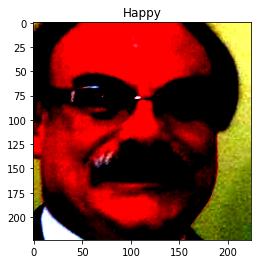

In [17]:
display_image(train_data[0][0],train_data[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


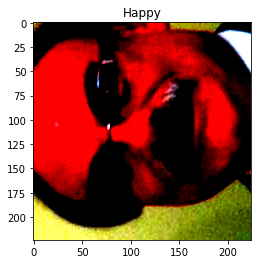

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


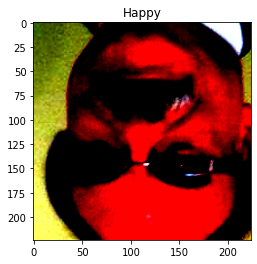

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


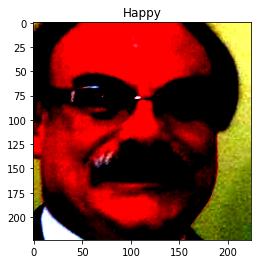

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


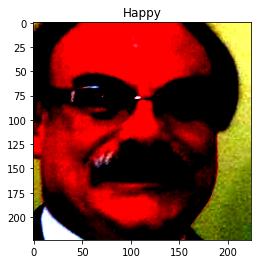

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


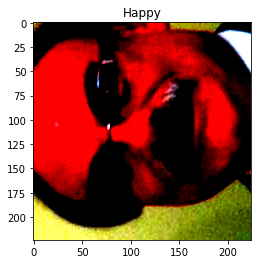

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


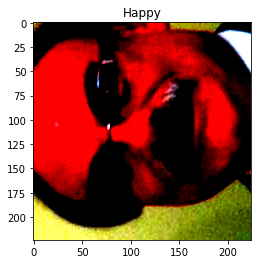

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


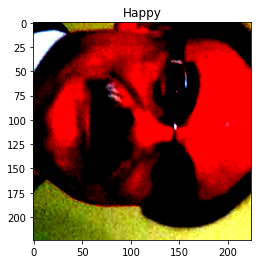

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


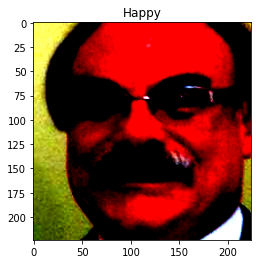

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


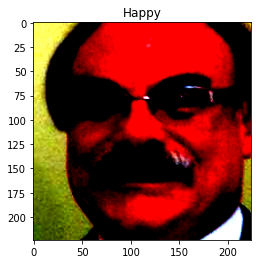

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


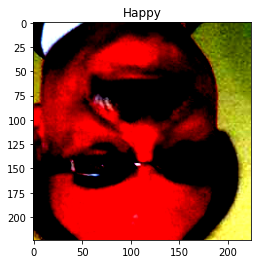

In [18]:
for _ in range(10):
    display_image(t_image.tran(train_data[0][0]),train_data[0][1])

In [19]:
model1.load_state_dict(torch.load(r"./01_data/modelrecent.pth"))

<All keys matched successfully>

In [20]:
#optimizer.load_state_dict(torch.load(r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizer1.pth"))

In [21]:
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [22]:
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']


In [23]:
print(len(train_data))

287651


In [25]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

100%|██████████| 287651/287651 [07:38<00:00, 627.34it/s]

{'Neutral': 74874, 'Happy': 134415, 'Sad': 25459, 'Surprise': 14090, 'Fear': 6378, 'Disgust': 3803, 'Anger': 24882, 'Contempt': 3750}


In [24]:
train_data.upsample()

Finding Class Counts...


100%|██████████| 287651/287651 [02:36<00:00, 1838.84it/s]


Balancing Class: Neutral


0it [00:00, ?it/s]


Balancing Class: Happy


0it [00:00, ?it/s]


Balancing Class: Sad


0it [00:00, ?it/s]


Balancing Class: Surprise


100%|██████████| 5910/5910 [00:00<00:00, 1182029.31it/s]


Balancing Class: Fear


100%|██████████| 13622/13622 [00:00<00:00, 1362038.93it/s]


Balancing Class: Disgust


100%|██████████| 16197/16197 [00:00<00:00, 1799463.40it/s]


Balancing Class: Anger


0it [00:00, ?it/s]


Balancing Class: Contempt


100%|██████████| 16250/16250 [00:00<00:00, 1476995.62it/s]


In [25]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

100%|██████████| 339630/339630 [06:46<00:00, 834.83it/s] 

{'Neutral': 74874, 'Happy': 134415, 'Sad': 25459, 'Surprise': 20000, 'Fear': 20000, 'Disgust': 20000, 'Anger': 24882, 'Contempt': 20000}


In [26]:
len(train_data)/batch

5306.71875

In [24]:
validation(val_loader,model1,loss1)


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]

test error-2.141886 
 Accuracy-48.012003%


In [28]:
validation_classes(val_loader_class,model1,loss1,0)

100%|██████████| 3999/3999 [00:13<00:00, 296.30it/s]

test error-5.230984 
 Accuracy-0.000000%


In [29]:
validation_classes(val_loader_class,model1,loss1,1)

100%|██████████| 3999/3999 [00:13<00:00, 306.78it/s]

test error-5.008721 
 Accuracy-0.000000%


In [30]:
validation_classes(val_loader_class,model1,loss1,2)

100%|██████████| 3999/3999 [00:12<00:00, 309.86it/s]

test error-5.831065 
 Accuracy-0.000000%


In [31]:
validation_classes(val_loader_class,model1,loss1,3)

100%|██████████| 3999/3999 [00:14<00:00, 277.60it/s]

test error-3.836865 
 Accuracy-0.000000%


In [32]:
validation_classes(val_loader_class,model1,loss1,4)

100%|██████████| 3999/3999 [00:13<00:00, 300.60it/s]

test error-3.526946 
 Accuracy-0.000000%


In [33]:
validation_classes(val_loader_class,model1,loss1,5)

100%|██████████| 3999/3999 [00:14<00:00, 284.46it/s]

test error-2.788252 
 Accuracy-0.000000%


In [34]:
validation_classes(val_loader_class,model1,loss1,6)

100%|██████████| 3999/3999 [00:12<00:00, 312.00it/s]

test error-5.866461 
 Accuracy-0.000000%


In [35]:
validation_classes(val_loader_class,model1,loss1,7)

100%|██████████| 3999/3999 [00:13<00:00, 295.35it/s]

test error-0.139584 
 Accuracy-100.000000%


In [27]:
# NO OF EPOCHS IS 5
epochs=10
for epoch in range(epochs):
    print(f'Epoch-{epoch}')
    train_w_transform(train_loader,model1,loss1,optimizer,t_image)
    validation(val_loader,model1,loss1)


Epoch-0


100%|██████████| 5307/5307 [24:09<00:00,  3.66it/s]


loss:0.000000 batch:5306/5307


100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


test error-75.837231 
 Accuracy-12.478120%
Epoch-1


100%|██████████| 5307/5307 [23:51<00:00,  3.71it/s]


loss:0.000000 batch:5306/5307


100%|██████████| 63/63 [00:23<00:00,  2.70it/s]


test error-1969.129573 
 Accuracy-12.478120%
Epoch-2


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.000000 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


test error-202.045195 
 Accuracy-12.478120%
Epoch-3


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.345709 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


test error-3.276867 
 Accuracy-12.478120%
Epoch-4


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.175796 batch:5306/5307


100%|██████████| 63/63 [00:23<00:00,  2.70it/s]


test error-3.880613 
 Accuracy-12.478120%
Epoch-5


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.172038 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.78it/s]


test error-3.876950 
 Accuracy-12.478120%
Epoch-6


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.166160 batch:5306/5307


100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


test error-3.893391 
 Accuracy-12.478120%
Epoch-7


100%|██████████| 5307/5307 [23:51<00:00,  3.71it/s]


loss:0.158510 batch:5306/5307


100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


test error-3.920415 
 Accuracy-12.478120%
Epoch-8


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.147958 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-3.970401 
 Accuracy-12.478120%
Epoch-9


100%|██████████| 5307/5307 [23:50<00:00,  3.71it/s]


loss:0.140569 batch:5306/5307


100%|██████████| 63/63 [00:23<00:00,  2.73it/s]

test error-4.027928 
 Accuracy-12.478120%


In [ ]:
torch.save(model1.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\modelrecent.pth")

In [ ]:
torch.save(optimizer.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizerrecent.pth")

In [53]:
torch.cuda.empty_cache()

In [54]:
torch.cuda.memory_summary(device='cuda', abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1774 MB |    3057 MB |    1438 TB |    1438 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1774 MB |    3057 MB |    1438 TB |    1438 TB |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |    2182 MB |    3852 MB |    3852 MB |    1670 MB |\n|--------------------------------------------------